# EE626 Course Project - Stock Price Predictor
Predict the future closing value of a given stock using a dataset of past prices with a Long Short - Term Memory Recurrent Neural Network

**Nishant Bhat - 180106032** <br>
**Aditi Madkaikar - 180106007** <br>
**Siddhant Jagtap - 180106050** <br>
**Tahir D'Mello - 180106055**



## Data Collection

In the following cells we download and save the needed dataset. 

   **Step 1 :** Get historical data from Yahoo finance

In [1]:
import pandas as pd
import yfinance as yf
data = yf.download('AAPL',start="2006-01-01",end='2021-02-28')# from January 1, 2006 to February 28, 2021
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,2.585000,2.669643,2.580357,2.669643,2.299533,807234400
2006-01-04,2.683214,2.713571,2.660714,2.677500,2.306301,619603600
2006-01-05,2.672500,2.675000,2.633929,2.656429,2.288151,449422400
2006-01-06,2.687500,2.739286,2.662500,2.725000,2.347216,704457600
2006-01-09,2.740357,2.757143,2.705000,2.716071,2.339525,675040800
...,...,...,...,...,...,...
2021-02-22,128.009995,129.720001,125.599998,126.000000,126.000000,103916400
2021-02-23,123.760002,126.709999,118.389999,125.860001,125.860001,158273000
2021-02-24,124.940002,125.559998,122.230003,125.349998,125.349998,111039900


**Step 2:** Write the data to a csv file.

In [2]:
data.to_csv('apple.csv',index = False)

## Preprocess the data

Normalise data to improve predictions

**Step 1 :** Import data from csv file.

In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv('apple.csv')
data.head()

,Open,High,Low,Close,Adj Close,Volume
0,2.585000,2.669643,2.580357,2.669643,2.299533,807234400
1,2.683214,2.713571,2.660714,2.677500,2.306301,619603600
2,2.672500,2.675000,2.633929,2.656429,2.288151,449422400
3,2.687500,2.739286,2.662500,2.725000,2.347216,704457600
4,2.740357,2.757143,2.705000,2.716071,2.339525,675040800


**Step 2 :** Drop unncessary columns

In [4]:
def remove_data(data): #Remove unneccesary columns from the data

    item = []
    open = []
    close = []
    volume = []

    #Loop through the stock data objects and store needed data
    i_counter = 0
    for i in range(0,len(data)):
        item.append(i_counter)
        open.append(data['Open'][i])
        close.append(data['Close'][i])
        volume.append(data['Volume'][i])
        i_counter += 1

    #Store in a DataFrame
    stocks = pd.DataFrame()
    stocks['Item'] = item
    stocks['Open'] = open
    stocks['Close'] = pd.to_numeric(close)
    stocks['Volume'] = pd.to_numeric(volume)

    return stocks #Returns DataFrame with columns as  ['Index','Open','Close','Volume']

stocks = remove_data(data)
stocks

,Item,Open,Close,Volume
0,0,2.585000,2.669643,807234400
1,1,2.683214,2.677500,619603600
2,2,2.672500,2.656429,449422400
3,3,2.687500,2.725000,704457600
4,4,2.740357,2.716071,675040800
...,...,...,...,...
3809,3809,128.009995,126.000000,103916400
3810,3810,123.760002,125.860001,158273000
3811,3811,124.940002,125.349998,111039900
3812,3812,124.680000,120.989998,148199500


**Step 3 :** Visualise data

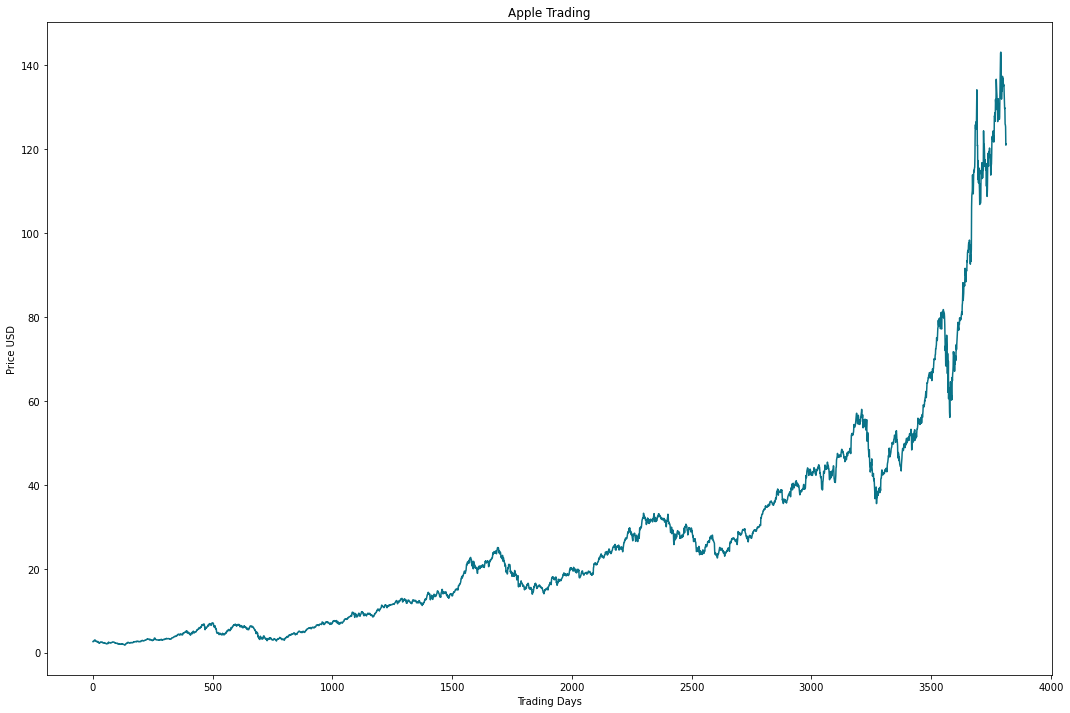

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)

fig, ax = plt.subplots()
ax.plot(stocks['Item'], stocks['Close'], '#0A7388')

plt.ylabel('Price USD')
plt.xlabel('Trading Days')
plt.title('Apple Trading')

plt.show()

**Step 3 :** Normalise the data using minmaxscaler function

In [6]:
from sklearn.preprocessing import MinMaxScaler

def normalise_data(data): #Normalises the data values using MinMaxScaler from sklearn
    
    scaler = MinMaxScaler()  #Initialize a scaler, then apply it to the features
    numerical = ['Open', 'Close', 'Volume']
    data[numerical] = scaler.fit_transform(data[numerical])

    return data #Returns DataFrame with normalised value for all the columns except index



stocks = normalise_data(stocks)
stocks.head()

,Item,Open,Close,Volume
0,0,0.005203,0.006084,0.228935
1,1,0.005896,0.006140,0.172548
2,2,0.005820,0.005991,0.121404
3,3,0.005926,0.006476,0.198048
4,4,0.006299,0.006413,0.189208


**Step 4 :** Visualize the data again

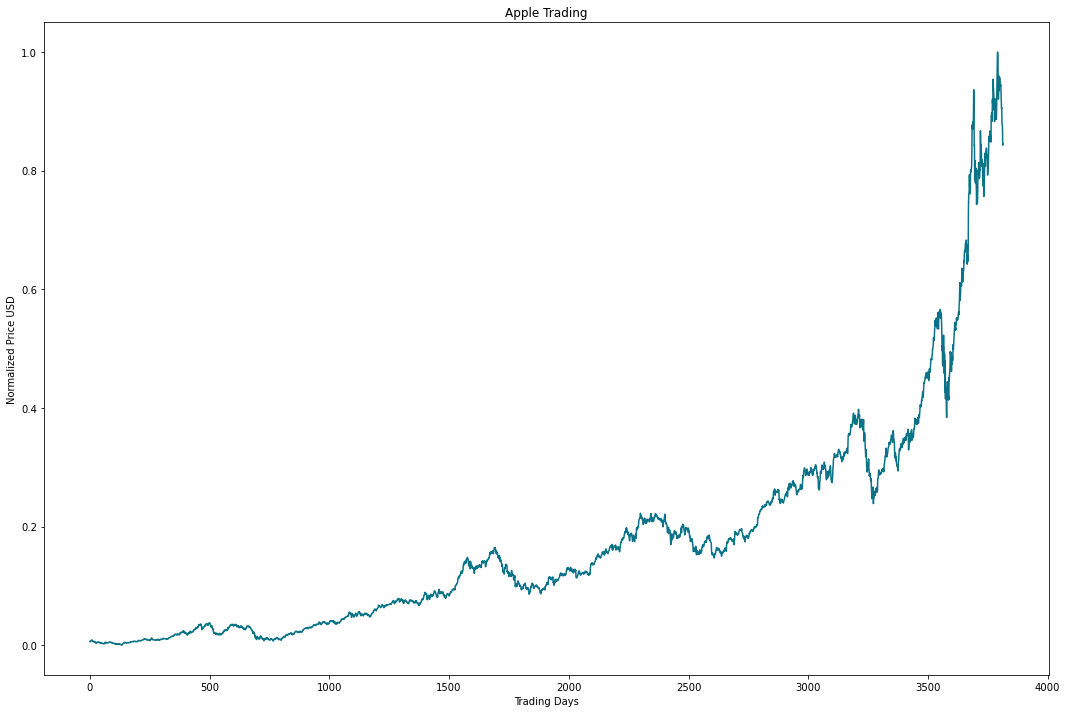

In [7]:
fig, ax = plt.subplots()
ax.plot(stocks['Item'], stocks['Close'], '#0A7388')

plt.ylabel('Normalized Price USD')
plt.xlabel('Trading Days')
plt.title('Apple Trading')

plt.show()


## Long-Short Term Memory Model

Build a LSTM to train and test on the data set.

### Basic LSTM Model

Building a basic LSTM model.

**Step 1 :** Importing libraries and data

In [8]:
import math
import pandas as pd
import numpy as np
from IPython.display import display

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import time

import LinearRegressionModel

stocks_data = stocks.drop(['Item'], axis =1)

stocks_data.head()

,Open,Close,Volume
0,0.005203,0.006084,0.228935
1,0.005896,0.006140,0.172548
2,0.005820,0.005991,0.121404
3,0.005926,0.006476,0.198048
4,0.006299,0.006413,0.189208


**Step 2** : Build needed functions

In [9]:
def train_test_split(stocks, prediction_time=1, test_data_size=450, unroll_length=50): 
#Split the data set into training and testing feature for Long Short Term Memory Model
    
    # training data
    test_data_cut = test_data_size + unroll_length + 1

    x_train = stocks[0:-prediction_time - test_data_cut].to_numpy()
    y_train = stocks[prediction_time:-test_data_cut]['Close'].to_numpy()

    # test data
    x_test = stocks[0 - test_data_cut:-prediction_time].to_numpy()
    y_test = stocks[prediction_time - test_data_cut:]['Close'].to_numpy()

    return x_train, x_test, y_train, y_test 
    #Returns X_train (training sets of feature), X_test(test sets of feature), y_train: training sets of label, 
    #y_test (test sets of label)


def unroll(data, sequence_length=24):
#Use different windows of past data to predict next data

    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
        
    return np.asarray(result) #Returns data sets with different window.

def build_basic_model(input_dim, output_dim, return_sequences):
# Builds a basic lstm model 

    model = Sequential()
    model.add(LSTM(
        input_shape=(None, input_dim),
        units=output_dim,
        return_sequences=return_sequences))

    model.add(LSTM(
        100,
        return_sequences=False))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    return model #Returns a basic LSTM model with 3 layers

**Step 3 :** Split train and test data and Unroll train and test data 

In [38]:
X_train, X_test,y_train, y_test = train_test_split(stocks_data, 5)

unroll_length = 50
X_train = unroll(X_train, unroll_length)
X_test = unroll(X_test, unroll_length)
y_train = y_train[-X_train.shape[0]:]
y_test = y_test[-X_test.shape[0]:]

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (3258, 50, 3)
y_train (3258,)
x_test (446, 50, 3)
y_test (446,)


**Step 4 :** Build a basic Long-Short Term Memory model

In [11]:
# build basic lstm model
model = build_basic_model(input_dim = X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

compilation time :  0.00598454475402832


**Step 5 :** Train the model

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_split=0.05)

97/97 [==============================] - 7s 44ms/step - loss: 0.0023 - val_loss: 5.3851e-04


**Step 6:** make prediction using test data

In [13]:
predictions = model.predict(X_test)
predictions

array([[0.34285164],
       [0.3403744 ],
       [0.33793417],
       [0.3355011 ],
       [0.3328522 ],
       [0.33034945],
       [0.32789743],
       [0.3253117 ],
       [0.32274038],
       [0.32020894],
       [0.31770042],
       [0.315394  ],
       [0.31314158],
       [0.31090653],
       [0.30900848],
       [0.30778277],
       [0.3071486 ],
       [0.30721068],
       [0.3080006 ],
       [0.30942824],
       [0.3112037 ],
       [0.31315538],
       [0.31500828],
       [0.31679735],
       [0.3187034 ],
       [0.32071072],
       [0.32278457],
       [0.3247083 ],
       [0.32648355],
       [0.32796526],
       [0.32931036],
       [0.33059254],
       [0.3316544 ],
       [0.3327901 ],
       [0.33394828],
       [0.3352021 ],
       [0.33646265],
       [0.33744204],
       [0.33818904],
       [0.33889785],
       [0.339542  ],
       [0.34015322],
       [0.3408377 ],
       [0.34153846],
       [0.34217218],
       [0.34280795],
       [0.34336084],
       [0.343

**Step 7:** Plot the results

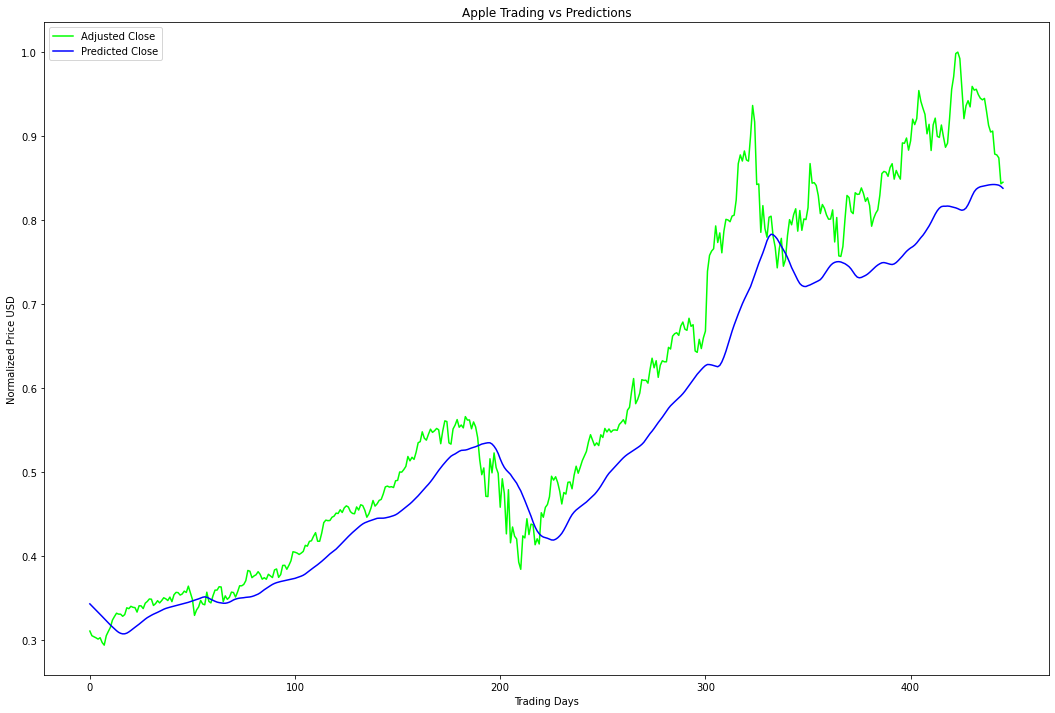

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price USD')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test, '#00FF00', label='Adjusted Close')
plt.plot(predictions, '#0000FF', label='Predicted Close')

#Set title
ax.set_title('Apple Trading vs Predictions')
ax.legend(loc='upper left')


plt.show()

**Step 8 :** Get the test scores

In [15]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00007812 MSE (0.00883852 RMSE)
Test Score: 0.00500748 MSE (0.07076352 RMSE)


### Improved LSTM Model

**Step 1 :** Build an improved LSTM model

In [16]:
def build_improved_model(input_dim, output_dim, return_sequences):
#Builds an improved Long Short term memory model using keras.layers.recurrent.lstm

    model = Sequential()
    model.add(LSTM(
        input_shape=(None, input_dim),
        units=output_dim,
        return_sequences=return_sequences))

    model.add(Dropout(0.2))

    model.add(LSTM(
        128,
        return_sequences=False))

    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    return model #Returns a 3 layered LSTM model

In [39]:
# Set up hyperparameters
batch_size = 100
epochs = 5

# build improved lstm model
model = build_improved_model( X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

compilation time :  0.003989458084106445


**Step 2 :** Train improved LSTM model

In [40]:
model.fit(X_train, 
          y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.05
         )

Epoch 1/5
31/31 - 6s - loss: 0.0020 - val_loss: 5.0892e-04
Epoch 2/5
31/31 - 2s - loss: 2.2179e-04 - val_loss: 5.2523e-04
Epoch 3/5
31/31 - 2s - loss: 1.8431e-04 - val_loss: 4.8083e-04
Epoch 4/5
31/31 - 2s - loss: 1.4108e-04 - val_loss: 4.7380e-04
Epoch 5/5
31/31 - 2s - loss: 1.3559e-04 - val_loss: 4.8637e-04


**Step 3 :** Make prediction on improved LSTM model

In [41]:
# Generate predictions 
predictions = model.predict(X_test, batch_size=batch_size)

**Step 4:** plot the results

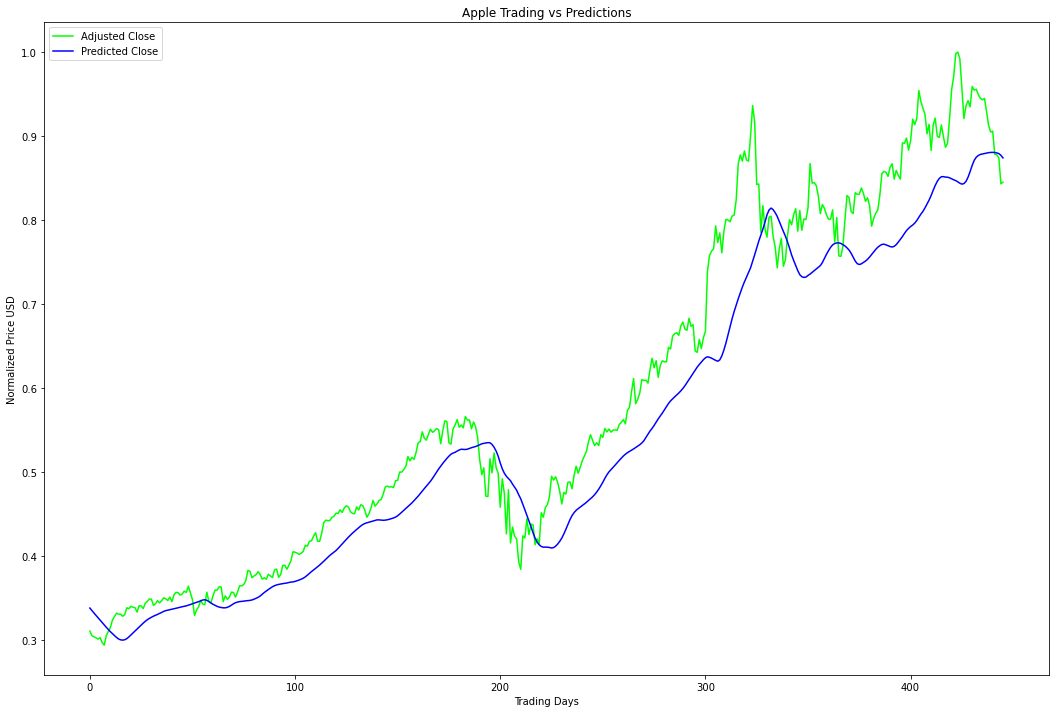

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price USD')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test, '#00FF00', label='Adjusted Close')
plt.plot(predictions, '#0000FF', label='Predicted Close')

#Set title
ax.set_title('Apple Trading vs Predictions')
ax.legend(loc='upper left')

plt.show()

**Step 5:** Get the test score

In [43]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00008033 MSE (0.00896253 RMSE)
Test Score: 0.00376286 MSE (0.06134217 RMSE)
